In [4]:
import numpy as np
import pandas as pd
import os
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import statistics
import seaborn as sns; sns.set(style="whitegrid")
import math

%matplotlib inline

In [12]:
df = pd.read_csv('datasets/data_cart.csv')#[['ABEV3', 'AZUL4', 'B3SA3', 'BBAS3', 'BBDC3']]
pos = df.shape[0]-160
#del df['Data']
y_symbol = 'CMIG4'
x_symbol = 'ENBR3'

S1 = df[x_symbol][pos:]
S2 = df[y_symbol][pos:]

NameError: name 'data' is not defined

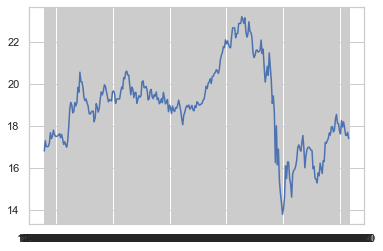

In [14]:
fig, ax = plt.subplots()
ax.plot('Data', 'ENBR3', data=df)

# format the ticks
"""ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)"""

# round to nearest years.
datemin = np.datetime64(data['Data'][0], 'Y')
datemax = np.datetime64(data['Data'][-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.show()

In [3]:
prices = df['AZUL4']